<a href="https://colab.research.google.com/github/TAUforPython/stohasticsignal/blob/main/Markov_process_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

полезные ссылки

https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/

https://timeseriesreasoning.com/contents/introduction-to-discrete-time-markov-processes/

In [ ]:
!pip install scipy

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

A Discrete Time Markov Chain can be used to describe the behavior of a system that jumps from one state to another state with a certain probability, and this probability of transition to the next state depends only on what state the system is in currently, i.e. it does not depend on which states the system was in prior to the current state

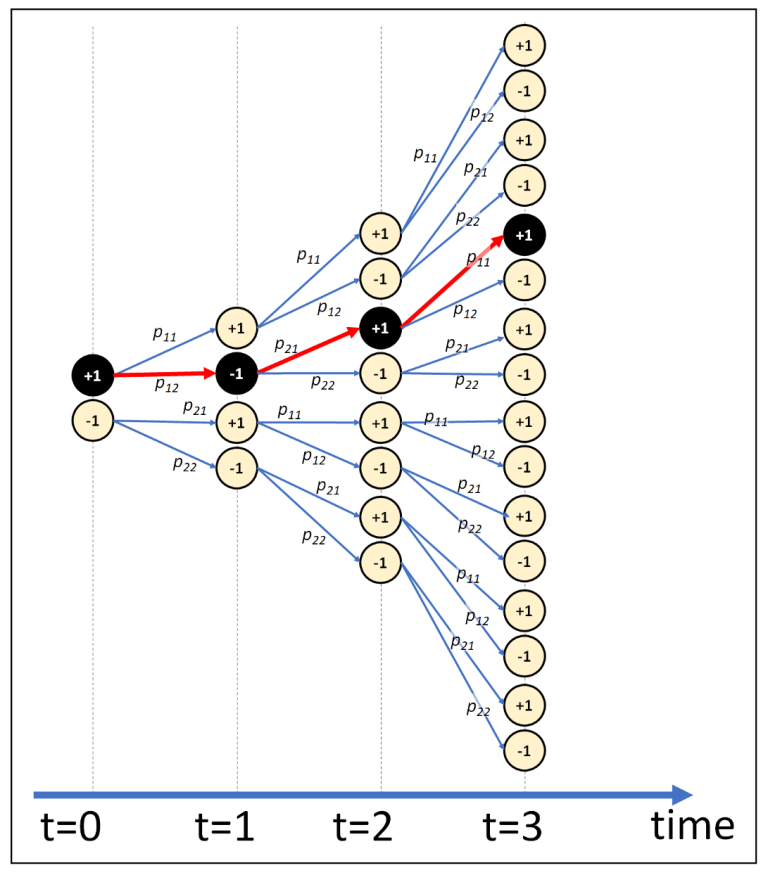

# Simple Markov Chain model

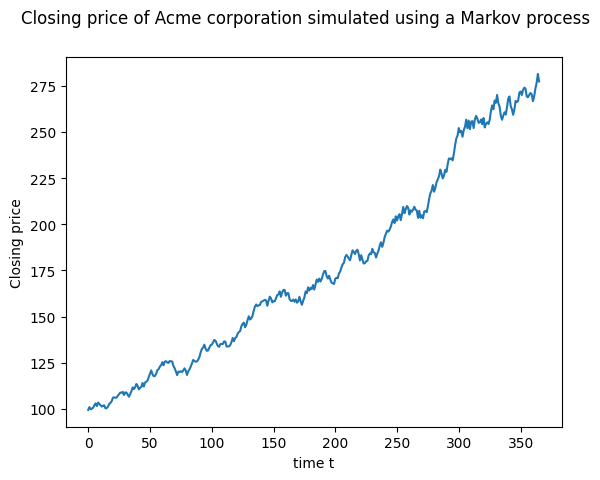

In [12]:
P=np.array([[0.6,0.4],[0.75,0.25]])

#Simulate the closing price of a company
closing_price = 100.0
#initialize pi_0
pi_0=np.array([0.5, 0.5])
#create a random delta in the range [0, 2.0]
delta = random.random() * 2
#generate a random number in the range [0.0, 1.0]
r = random.random()
#if r <= P(X_t = +1), increase the closing price by delta,
#else decrease the closing price by delta
if r <= pi_0[0]:
    closing_price = closing_price*(100+delta)/100
else:
    closing_price = max(closing_price*(100-delta)/100,1.0)
#accumulate the new closing price
closing_prices = [closing_price]
P_mul=P.copy()
T=365
#now repeat this procedure 365 times
for i in range(T):
    #calculate the i-step transition matrix P^i
    P_mul=np.matmul(P_mul,P)
    #multiply it by pi_0 to get the state probability for time i
    pi_t = np.matmul(pi_0,P_mul)
    # create a random delta in the range [0, 2.0]
    delta = random.random() * 2
    # generate a random number in the range [0.0, 1.0]
    r = random.random()
    # if r <= P(X_t = +1), increase the closing price by delta,
    # else decrease the closing price by delta
    if r <= pi_t[0]:
        closing_price = max(closing_price*(100+delta)/100, 1.0)
    else:
        closing_price = closing_price*(100-delta)/100
    # accumulate the new closing price
    closing_prices.append(closing_price)

#plot all the accumulated closing prices
fig = plt.figure()
fig.suptitle('Closing price of Acme corporation simulated using a Markov process')
plt.xlabel('time t')
plt.ylabel('Closing price')
plt.plot(range(T+1), closing_prices)
plt.show()

# Second example

In [13]:
def equilibrium_distribution(p_transition):
    n_states = p_transition.shape[0]
    A = np.append(
        arr=p_transition.T - np.eye(n_states),
        values=np.ones(n_states).reshape(1, -1),
        axis=0
    )
    b = np.transpose(np.array([0] * n_states + [1]))
    p_eq = np.linalg.solve(
        a=np.transpose(A).dot(A),
        b=np.transpose(A).dot(b)
    )
    return p_eq

In [14]:
from scipy.stats import multinomial
from typing import List

def markov_sequence(p_init: np.array, p_transition: np.array, sequence_length: int) -> List[int]:
    """
    Generate a Markov sequence based on p_init and p_transition.
    """
    if p_init is None:
        p_init = equilibrium_distribution(p_transition)
    initial_state = list(multinomial.rvs(1, p_init)).index(1)

    states = [initial_state]
    for _ in range(sequence_length - 1):
        p_tr = p_transition[states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        states.append(new_state)
    return states

In [15]:
p_init = np.array([0.1, 0.8, 0.1])
p_transition = np.array(
    [[0.90, 0.05, 0.05],
     [0.01, 0.90, 0.09],
     [0.07, 0.03, 0.9]])

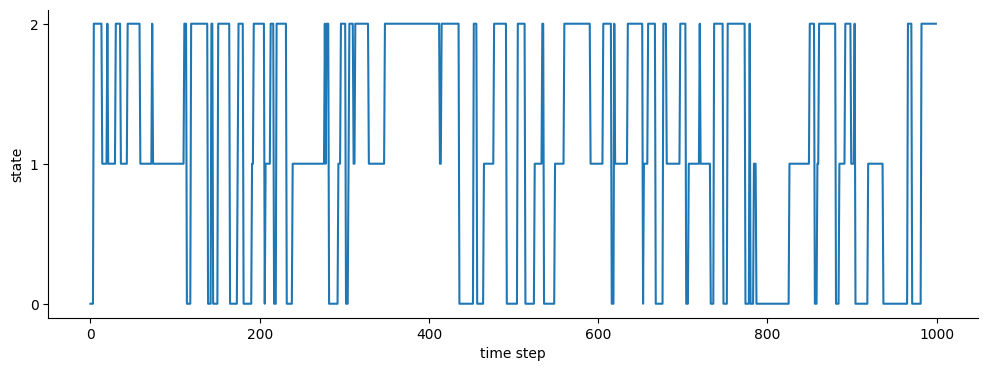

In [16]:
import seaborn as sns

states = markov_sequence(p_init, p_transition, sequence_length=1000)
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(states)
plt.xlabel("time step")
plt.ylabel("state")
plt.yticks([0, 1, 2])
sns.despine()

In [17]:
from scipy.stats import norm

def gaussian_emissions(states: List[int], mus: List[float], sigmas: List[float]) -> List[float]:
    emissions = []
    for state in states:
        loc = mus[state]
        scale = sigmas[state]
        e = norm.rvs(loc=loc, scale=scale)
        emissions.append(e)
    return emissions

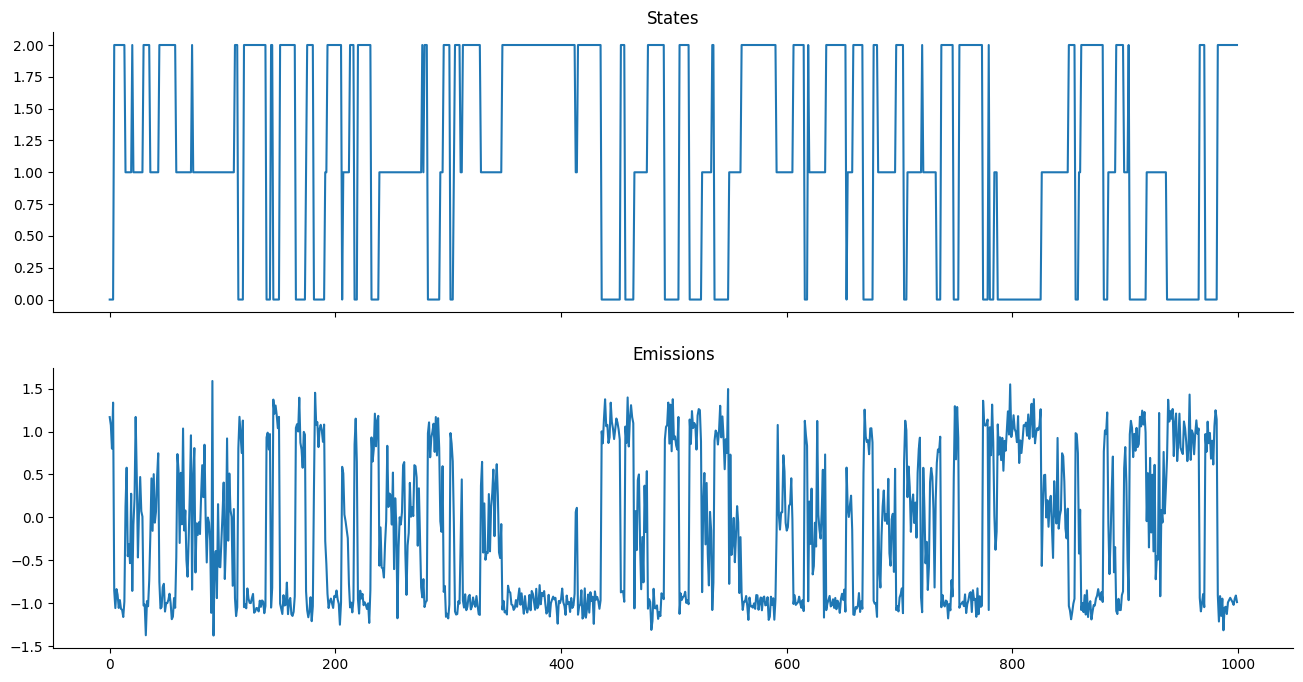

In [18]:
gaussian_ems = gaussian_emissions(states, mus=[1, 0, -1], sigmas=[0.2, 0.5, 0.1])

def plot_emissions(states, emissions):
    fig, axes = plt.subplots(figsize=(16, 8), nrows=2, ncols=1, sharex=True)

    axes[0].plot(states)
    axes[0].set_title("States")
    axes[1].plot(emissions)
    axes[1].set_title("Emissions")
    sns.despine();

plot_emissions(states, gaussian_ems)